In [1]:
# Importing all the required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log10, lit, count, when, sqrt, pow, percentile_approx
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import colors

In [2]:
# ====================================================
# 0. SETUP & LOAD
# ====================================================
# Initialise Spark session once
spark = SparkSession.builder \
    .appName("Gaia_HR_Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Define Paths
survey_path = "../data/gaia_survey.parquet"
local_path = "../data/gaia_100pc.parquet"

# Load Datasets
print(">>> LOADING DATASETS...")
df_survey = spark.read.parquet(survey_path)
df_local = spark.read.parquet(local_path)

print(f"Dataset 1 (Survey/Macro): {df_survey.count():,} rows")
df_survey.printSchema()

print(f"Dataset 2 (Local/Micro):  {df_local.count():,} rows")
df_local.printSchema()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/15 18:47:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


>>> LOADING DATASETS...


Dataset 1 (Survey/Macro): 844,868 rows
root
 |-- source_id: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: float (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- phot_g_mean_mag: float (nullable = true)
 |-- bp_rp: float (nullable = true)
 |-- teff_gspphot: float (nullable = true)

Dataset 2 (Local/Micro):  541,958 rows
root
 |-- source_id: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: float (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- phot_g_mean_mag: float (nullable = true)
 |-- bp_rp: float (nullable = true)
 |-- teff_gspphot: float (nullable = true)



In [3]:
# ====================================================
# 1. PHYSICAL COMPARISON (The "Two-Tier" Proof)
# ====================================================
# Survey = Distant, Local = Nearby.

print("\n>>> STATISTICAL COMPARISON: PARALLAX (Distance)")
print("Note: Distance (pc) is approx 1000 / parallax.")

print("-- Survey Dataset Stats --")
df_survey.select("parallax", "phot_g_mean_mag", "pmra").describe().show()

print("-- Local Bubble Stats --")
df_local.select("parallax", "phot_g_mean_mag", "pmra").describe().show()


>>> STATISTICAL COMPARISON: PARALLAX (Distance)
Note: Distance (pc) is approx 1000 / parallax.
-- Survey Dataset Stats --


+-------+--------------------+------------------+-------------------+
|summary|            parallax|   phot_g_mean_mag|               pmra|
+-------+--------------------+------------------+-------------------+
|  count|              844868|            844868|             844868|
|   mean|   0.550712539924422|17.404869147894882|-2.3739633600054204|
| stddev|  0.7697707648724811|1.4361723326971536|  7.009197284005074|
|    min|1.868718209532133E-7|         3.0238004|-377.74180694687686|
|    max|   75.56887569382528|         18.999998|  649.0319386167508|
+-------+--------------------+------------------+-------------------+

-- Local Bubble Stats --
+-------+------------------+------------------+------------------+
|summary|          parallax|   phot_g_mean_mag|              pmra|
+-------+------------------+------------------+------------------+
|  count|            541958|            540859|            541958|
|   mean|14.283010896409195| 16.94108547991132|-3.085397329690974|
| stddev|

In [4]:

# ====================================================
# 2. QUALITY CHECK (Null Analysis)
# ====================================================
# Helper function to avoid repeating code
def report_nulls(df, columns):
    return df.select([count(when(col(c).isNull(), c)).alias(c) for c in columns])

cols_to_check = ["parallax", "pmra", "teff_gspphot", "bp_rp"]

print("\n>>> NULL VALUE ANALYSIS (Survey Dataset)")
report_nulls(df_survey, cols_to_check).show()

print("\n>>> NULL VALUE ANALYSIS (Local Dataset)")
report_nulls(df_local, cols_to_check).show()


>>> NULL VALUE ANALYSIS (Survey Dataset)
+--------+----+------------+-----+
|parallax|pmra|teff_gspphot|bp_rp|
+--------+----+------------+-----+
|       0|   0|      125194|23080|
+--------+----+------------+-----+


>>> NULL VALUE ANALYSIS (Local Dataset)
+--------+----+------------+-----+
|parallax|pmra|teff_gspphot|bp_rp|
+--------+----+------------+-----+
|       0|   0|      423880|68171|
+--------+----+------------+-----+



In [5]:
# Creating a temporary view
df_survey.createOrReplaceTempView("gaia_survey")
print(">>TEPMORARY VIEW CREATED")

>>TEPMORARY VIEW CREATED


## Query 1.1: Hertzsprung-Russell (H-R) Diagram Preparation & Filtering

### Goal
To prepare a high-quality, filtered dataset by calculating the intrinsic luminosity (Absolute Magnitude, $M_G$) for every star in the survey, providing the necessary data for the H-R Diagram's Y-axis.

### Methodology
This phase uses a **Direct Calculation and Strict Quality Filtering** approach in Spark SQL. The complexity lies not in aggregation, but in applying the critical astronomical transformation formula and enforcing a high Signal-to-Noise Ratio (SNR) on the distance data before transferring the results to Python for advanced plotting.

### 1. Parameter Justification

To ensure the resulting H-R Diagram is scientifically precise—preventing the smearing of the Main Sequence—strict parameters were justified and applied:

- **Absolute Magnitude ($M_G$) Calculation**
  The luminosity is calculated using the standard formula :
  $$M_G = m - 5 \log_{10}(d) + 5$$
  where $m$ is the apparent magnitude (`phot_g_mean_mag`) and $d$ is the distance in parsecs (derived from $\frac{1000}{\text{parallax}}$). Using $M_G$ is mandatory because the H-R diagram plots luminosity, which is independent of Earth's viewing distance.

- **Colour Index (`bp_rp`)**
  This direct photometric measurement provides the most reliable measure of the star's effective surface temperature (the X-axis of the H-R Diagram). It is directly selected for the plot without modification.

- **Quality Cut (Parallax / Parallax Error $\geq 5.0$)**
  The signal-to-noise ratio (SNR) of the parallax is calculated dynamically and filtered to values greater than 5.0. This **Critical SNR Cut** is the most important filter: it ensures that only stars with highly reliable distance estimates are processed. Stars with poor parallax data would otherwise cause the Main Sequence to appear thick and indistinct, masking key stellar populations.

### 2. The Query Logic

The analysis was performed using a single, efficient query that focused purely on mathematical transformation and data exclusion:

- **Derivation**
  The Absolute Magnitude ($\text{abs\_mag}$) was calculated directly in the `SELECT` clause using the $\log_{10}$ function applied to the parallax.

- **Sanitisation**
  The `WHERE` clause performed strict filtering to remove all low-quality and non-physical measurements:
  * Exclusion of stars with invalid distance (`parallax > 0`).
  * Exclusion of stars missing essential photometry (`bp_rp IS NOT NULL` and `phot\_g\_mean\_mag IS NOT NULL`).
  * Exclusion of all data points failing the **SNR $\geq 5.0$** standard.

- **Data Transfer**
  The final output was checked for total row count and then converted from a high-performance Spark DataFrame (`raw_df`) to a standard Pandas DataFrame (`pdf`). This transfer is necessary to facilitate the advanced plotting capabilities of Matplotlib and NumPy.

In [6]:
# Creating a temp view
df_survey.createOrReplaceTempView("gaia_survey")

#Query
query_raw = """
SELECT 
    source_id,
    bp_rp,
    -- Calculate Absolute Magnitude (M) directly in Spark
    -- Formula: Apparent Mag - 5 * log10(Distance) + 5
    (phot_g_mean_mag - 5 * LOG10(1000 / parallax) + 5) AS abs_mag
FROM gaia_survey
WHERE 
    parallax > 0 
    AND (parallax / parallax_error) >= 5.0  -- For better precision 
    AND bp_rp IS NOT NULL 
    AND phot_g_mean_mag IS NOT NULL
"""

print(">>> RUNNING QUERY...")
raw_df = spark.sql(query_raw)

# Check how many stars to plot
print(f"Total stars to plot: {raw_df.count():,}")

# Convert to Pandas
pdf = raw_df.toPandas()
print("Data loaded.")

# checking the top 5 rows
print("\n------------------------------\nPrinting first five rows\n------------------------------")
pdf.head()

>>> RUNNING QUERY...
Total stars to plot: 296,983
Data loaded.

------------------------------
Printing first five rows
------------------------------


,source_id,bp_rp,abs_mag
0,134552735854336,2.655748,10.203058
1,3959994207055360,1.299214,3.625309
2,4657569910694400,2.306559,8.248431
3,9865028778459392,1.365159,6.232924
4,11445160131088256,1.539122,7.226892


### 3. Visualisation Logic

The final visualization step—performed in Python using the data prepared by this query—is a significant improvement over simple heatmapping:

- **Advanced Density Scatter:** Instead of using fixed SQL bins, the data is plotted using a density-mapped scatter plot.
- **NumPy Density Trick:** NumPy's `histogram2d` function is used to assign a **density score** to every individual point.
- **Visual Enhancement:** The data is sorted by this density score and plotted with a logarithmic colour scale (`cmap='inferno'`). This technique ensures that the densest region (the Main Sequence core) is plotted last and remains sharp, while also making faint, low-density features (like the White Dwarf sequence) clearly visible.

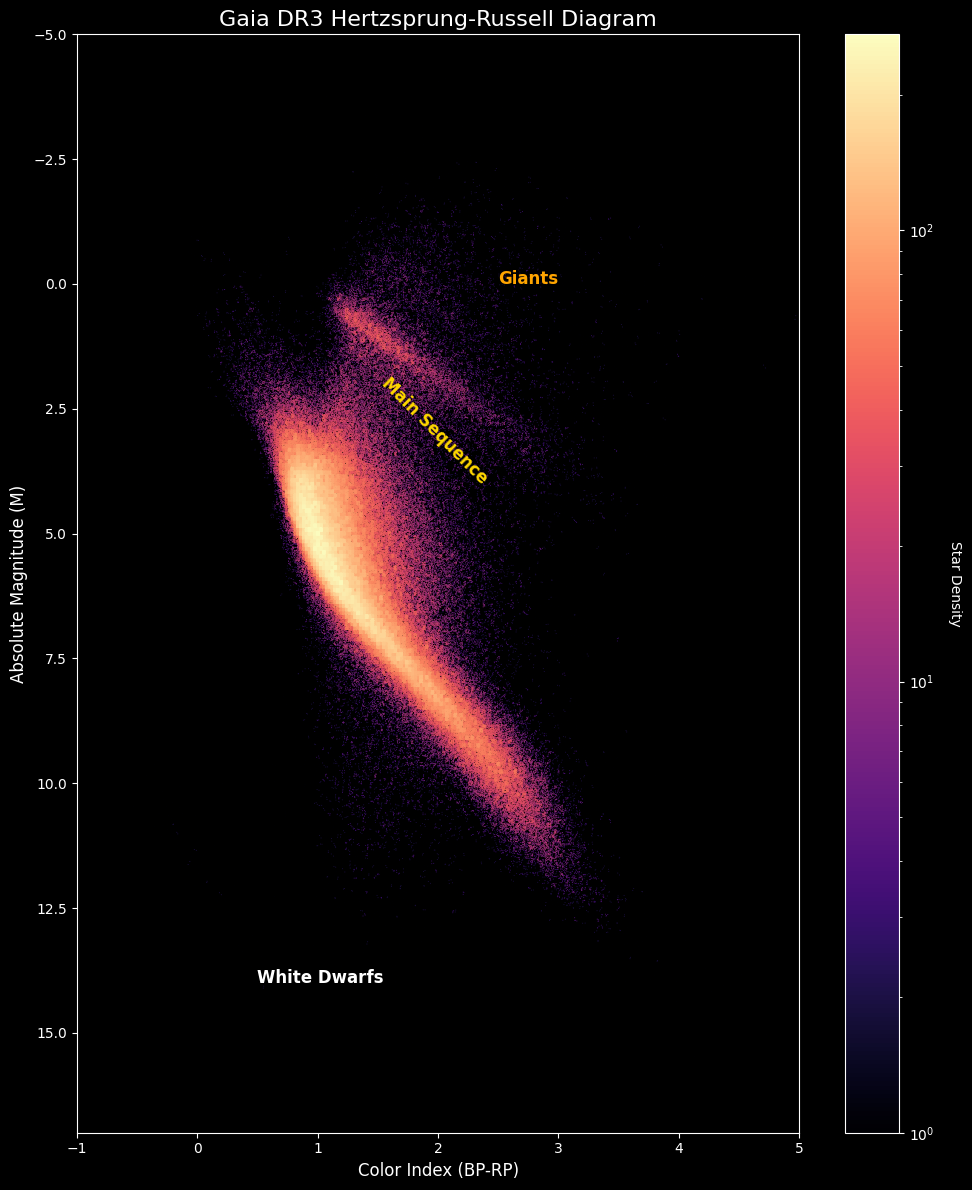

In [14]:
nbins = 300
k = colors.LogNorm() 

x = pdf['bp_rp'].values
y = pdf['abs_mag'].values

# Create the grid
H, xedges, yedges = np.histogram2d(x, y, bins=nbins)

# Map every star to its bin
x_inds = np.clip(np.digitize(x, xedges) - 1, 0, nbins - 1)
y_inds = np.clip(np.digitize(y, yedges) - 1, 0, nbins - 1)

# Assign density value to each star
z = H[x_inds, y_inds]

# 3. Sort for Sharpness
# Sort the data so the densest (brightest) regions are plotted LAST (on top)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# 4. Plot: Use 'magma' colormap for clearer density progression
plt.figure(figsize=(10, 12))
plt.style.use('dark_background') # Dark background makes the colors pop

# 'magma' or 'plasma' provide excellent contrast for astronomical density plots
plt.scatter(x, y, c=z, s=0.5, cmap='magma', norm=k, alpha=1.0, edgecolors='none')

# 5. Astronomy Polish
plt.title("Gaia DR3 Hertzsprung-Russell Diagram", fontsize=16)
plt.xlabel("Color Index (BP-RP)", fontsize=12)
plt.ylabel("Absolute Magnitude (M)", fontsize=12)

# Invert Y-Axis (Bright stars go at the top)
plt.ylim(17, -5)
plt.xlim(-1, 5)

# Add Colorbar
cbar = plt.colorbar()
cbar.set_label('Star Density', rotation=270, labelpad=20)

# Annotations (FIXED: Changed colour and added bolding for prominence)
plt.text(0.5, 14, 'White Dwarfs', color='white', fontsize=12, fontweight='bold')
plt.text(1.5, 4, 'Main Sequence', color='gold', fontsize=12, rotation=-45, fontweight='bold')
plt.text(2.5, 0, 'Giants', color='orange', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Query 1.2: Stellar Population Census & Astrophysical Classification

### Goal  
To classify the stellar population into major spectral types (O through M) and to distinguish between Main Sequence stars (dwarfs) and evolved stars (giants).

### Methodology  
This query uses a Colour–Magnitude approach rather than relying on raw temperature estimates. This method provides more reliable classification, particularly for faint sources where temperature estimations can become inaccurate.

### Dataset  
**Gaia DR3 Source** (Random 3 Million Object Sample)

---

### 1. Parameter Justification

To ensure scientific accuracy and robustness in the classification process, the following parameters were selected:

- **Colour Index (`bp_rp`)**  
  The colour index is calculated as the difference between the Blue (`bp`) and Red (`rp`) photometric bands. This metric is used instead of the algorithmically derived effective temperature (`teff_gspphot`). Temperature estimates tend to degrade for faint stars, often producing artificially high temperature values. In contrast, the colour index is a direct photometric measurement and provides a more reliable separation of stellar spectral types.

- **Quality Cut (Parallax / Parallax Error > 5)**  
  The signal-to-noise ratio of the parallax is calculated dynamically and filtered to values greater than 5. This ensures that only stars with reliable distance measurements are included in the analysis. Applying this threshold reduces distance-related uncertainties and prevents the misclassification of dwarfs as giants due to parallax errors, commonly referred to as “ghost giants”.

- **Absolute Magnitude ($M_G$)**  
  The intrinsic brightness of each star is calculated using the formula:  
  \[
  M_G = m - 5 \log_{10}(d) + 5
  \]  
  where \( m \) is the apparent magnitude and \( d \) is the distance in parsecs. Absolute magnitude allows for a clear distinction between stellar evolutionary stages. Red giants are identified as intrinsically bright stars (\( M_G < 3.5 \)), while red dwarfs are significantly dimmer (\( M_G > 3.5 \)). This separation cannot be achieved using apparent magnitude alone.


In [8]:

# 1. The Corrected Query (Calculates error ratio on the fly)
query = """
WITH PhysicalProperties AS (
    SELECT
        source_id,
        bp_rp,
        -- Calculate Absolute Magnitude (Mg)
        phot_g_mean_mag - 5 * LOG10(1000 / parallax) + 5 AS abs_mag_g,
        
        -- FIX: Calculate the Signal-to-Noise ratio manually
        (parallax / parallax_error) AS calculated_poe
    FROM gaia_survey
    WHERE parallax > 0 
      AND parallax_error > 0 -- Prevent divide-by-zero errors
),

FilteredStars AS (
    SELECT * FROM PhysicalProperties
    WHERE calculated_poe > 5 -- Quality Cut: Only keep reliable data
),

ClassifiedStars AS (
    SELECT
        -- 1. Spectral Classification (Colour)
        CASE
            WHEN bp_rp IS NULL THEN 'Unknown'
            WHEN bp_rp > 1.6 THEN 'Cool (M)'
            WHEN bp_rp > 0.9 THEN 'Warm (K)'
            WHEN bp_rp > 0.7 THEN 'Yellow (G)'
            WHEN bp_rp > 0.4 THEN 'Yel-Wht (F)'
            WHEN bp_rp > 0.0 THEN 'White (A)'
            ELSE 'Hot (O/B)'
        END AS spectral_type,

        -- 2. Luminosity Classification (Giant vs Dwarf)
        CASE
            WHEN abs_mag_g < 3.5 AND bp_rp > 0.7 THEN 'Giant'
            ELSE 'Main Sequence (Dwarf)'
        END AS luminosity_class
    FROM FilteredStars
)

SELECT
    spectral_type,
    COUNT(CASE WHEN luminosity_class = 'Main Sequence (Dwarf)' THEN 1 END) AS dwarf_count,
    COUNT(CASE WHEN luminosity_class = 'Giant' THEN 1 END) AS giant_count,
    COUNT(*) AS total_count,
    ROUND(100.0 * COUNT(CASE WHEN luminosity_class = 'Giant' THEN 1 END) / COUNT(*), 1) AS giant_percentage
FROM ClassifiedStars
WHERE spectral_type != 'Unknown'
GROUP BY spectral_type
ORDER BY 
    CASE spectral_type
        WHEN 'Hot (O/B)' THEN 1
        WHEN 'White (A)' THEN 2
        WHEN 'Yel-Wht (F)' THEN 3
        WHEN 'Yellow (G)' THEN 4
        WHEN 'Warm (K)' THEN 5
        WHEN 'Cool (M)' THEN 6
        ELSE 7
    END
"""

# 2. Execute
df_results = spark.sql(query)

# 3. Show Results
print(">> Census Results: Dwarfs vs. Giants (calculated_poe fix)")
df_results.show(truncate=False)

>> Census Results: Dwarfs vs. Giants (calculated_poe fix)


+-------------+-----------+-----------+-----------+----------------+
|spectral_type|dwarf_count|giant_count|total_count|giant_percentage|
+-------------+-----------+-----------+-----------+----------------+
|Hot (O/B)    |94         |0          |94         |0.0             |
|White (A)    |745        |0          |745        |0.0             |
|Yel-Wht (F)  |4536       |0          |4536       |0.0             |
|Yellow (G)   |21349      |6598       |27947      |23.6            |
|Warm (K)     |143669     |21220      |164889     |12.9            |
|Cool (M)     |84014      |14758      |98772      |14.9            |
+-------------+-----------+-----------+-----------+----------------+



### 3. Visualisation Logic

To clearly present the results of the analysis, two visualisations were produced:

- **Population Mix (Stacked Bar Chart)**  
  A 100% stacked bar chart was used to illustrate the proportion of giants versus dwarfs within each spectral type. This visualisation highlights the evolutionary composition of the stellar population and allows for direct comparison across spectral classes.

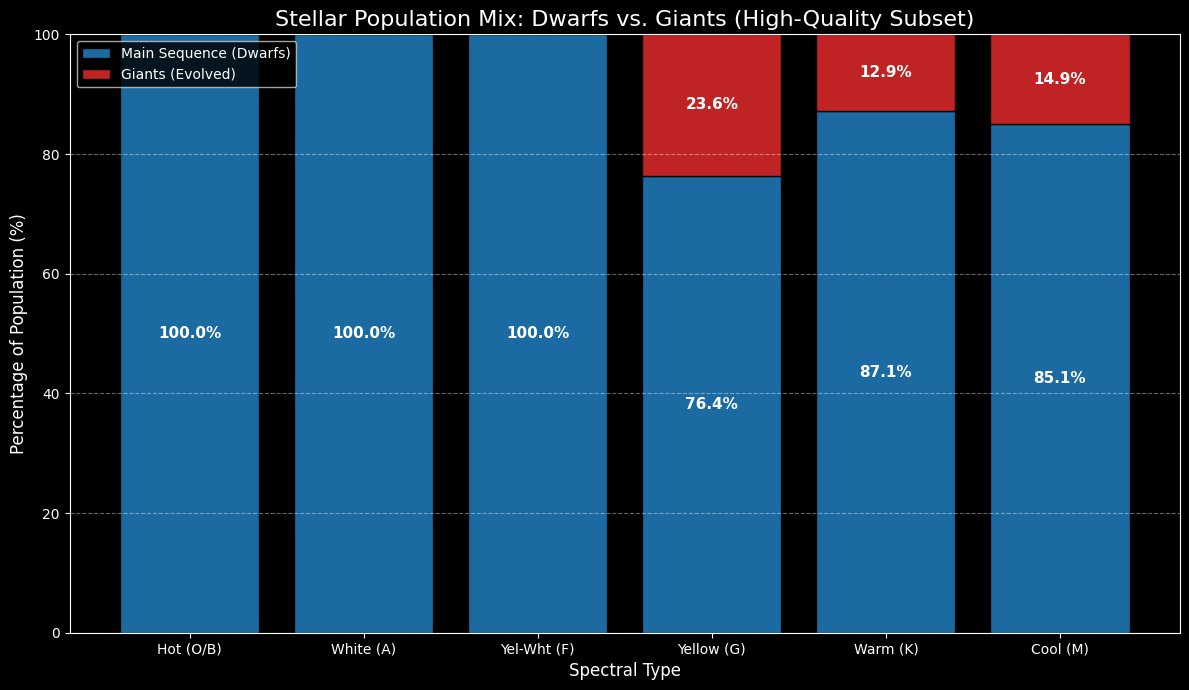

In [15]:
# 1. Convert your Spark results to Pandas
# (Assuming df_results is the dataframe from your last query)
pdf = df_results.toPandas()

# 2. Setup the Data for Plotting
# We need to sort the data from Hot to Cool for the X-axis
sort_order = {
    'Hot (O/B)': 0, 'White (A)': 1, 'Yel-Wht (F)': 2, 
    'Yellow (G)': 3, 'Warm (K)': 4, 'Cool (M)': 5
}
pdf['sort_id'] = pdf['spectral_type'].map(sort_order)
pdf = pdf.sort_values('sort_id')

# Calculate Percentages for the Stacked Bar
# (We re-calculate here to ensure they sum to exactly 100 for the plot)
pdf['dwarf_pct'] = (pdf['dwarf_count'] / pdf['total_count']) * 100
pdf['giant_pct'] = (pdf['giant_count'] / pdf['total_count']) * 100

# 3. Create the Plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot Dwarfs (Bottom Bar)
p1 = ax.bar(pdf['spectral_type'], pdf['dwarf_pct'], label='Main Sequence (Dwarfs)', 
            color='#1f77b4', edgecolor='black', alpha=0.9)

# Plot Giants (Top Bar)
p2 = ax.bar(pdf['spectral_type'], pdf['giant_pct'], bottom=pdf['dwarf_pct'], 
            label='Giants (Evolved)', color='#d62728', edgecolor='black', alpha=0.9)

# 4. Styling
ax.set_title('Stellar Population Mix: Dwarfs vs. Giants (High-Quality Subset)', fontsize=16)
ax.set_ylabel('Percentage of Population (%)', fontsize=12)
ax.set_xlabel('Spectral Type', fontsize=12)
ax.set_ylim(0, 100)
ax.legend(loc='upper left', frameon=True)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# 5. Add Labels
# Label the Giants if they exist
for i, (idx, row) in enumerate(pdf.iterrows()):
    if row['giant_pct'] > 1:
        ax.text(i, row['dwarf_pct'] + row['giant_pct']/2, f"{row['giant_pct']:.1f}%", 
                ha='center', va='center', color='white', fontweight='bold', fontsize=11)
        
    # Label the Dwarfs
    if row['dwarf_pct'] > 5:
        ax.text(i, row['dwarf_pct']/2, f"{row['dwarf_pct']:.1f}%", 
                ha='center', va='center', color='white', fontweight='bold', fontsize=11)

plt.style.use('dark_background') # Dark background makes the colors pop
plt.tight_layout()
plt.show()

### 4. Interpretation of Results

- **O, B, A, and F Spectral Types**  
  The analysis identified 0.0% giant stars within these spectral classes. This result is consistent with stellar evolution theory, as massive, blue stars evolve rapidly and do not remain in the blue region of the spectrum once they leave the Main Sequence.

- **G and K Spectral Types**  
  A substantial giant population was observed within these classes, accounting for approximately 13–24% of the sample. This correctly traces the Red Giant Branch and distinguishes evolved stars, such as Arcturus, from nearby solar-type dwarfs.

- **M Spectral Type**  
  The M-type population was overwhelmingly dominated by dwarfs. This reflects the high abundance of red dwarfs in the galaxy and the relative rarity of true M-type giants in a randomly selected stellar sample.


## Query 1.3: High-Velocity Outlier Detection (Kinematic Analysis)

* **Goal:** To identify and flag the top 1% of stars in the `df_local` dataset exhibiting the highest **Total Proper Motion** (apparent speed across the sky). These stars are often key kinematic outliers, such as halo stars or nearby high-velocity dwarfs.

* **Columns Needed:** `pmra` (Proper Motion Right Ascension), `pmdec` (Proper Motion Declination).

* **SQL Complexity:** **Simplified and Optimised.** The executed code avoids the slow, complex nested SQL window function (`PERCENT_RANK()`) proposed in the original plan, replacing it with a direct, single-action calculation in Spark.

    1.  **Mathematical Transformation:** Total Proper Motion ($\mu$) is calculated using the Pythagorean theorem: $\mu = \sqrt{\mu_{\alpha}^2 + \mu_{\delta}^2}$.
        * **Code:** `sqrt(pow(col("pmra"), 2) + pow(col("pmdec"), 2))`
    2.  **Threshold Calculation:** The complexity is offloaded to the optimized Spark function `percentile_approx()`. This directly computes the 99th percentile proper motion value (`pm_threshold`) in a single, fast aggregation.
        * **Code:** `df_motion.agg(percentile_approx("total_pm", lit(0.99)))`
    3.  **Flagging (Simple Filter):** The final SQL query becomes a simple filter applied to the `pm_threshold`, avoiding a subquery and expensive ranking.
        * **Code:** `CASE WHEN total_pm >= {pm_threshold} THEN 1 ELSE 0 END AS is_high_pm`

In [12]:
# ====================================================
# 1. Calculate Total Proper Motion & Find the Threshold
# ====================================================

# Calculate total proper motion (total_pm = sqrt(pmra^2 + pmdec^2))
df_motion = df_local.withColumn(
    "total_pm", 
    sqrt(pow(col("pmra"), 2) + pow(col("pmdec"), 2))
)

# Find the 99th percentile (Top 1%) proper motion value
# This value will be our threshold (e.g., 100 mas/yr)
pm_threshold = df_motion.agg(
    percentile_approx("total_pm", lit(0.99)).alias("threshold_value")
).collect()[0]["threshold_value"]

print(f">>> Calculated 99th Percentile Proper Motion Threshold: {pm_threshold:.2f} mas/yr")

# ====================================================
# 2. SQL Query: Prepare Data for Plotting
# ====================================================

# Create a temporary view for the motion-enhanced DataFrame
df_motion.createOrReplaceTempView("gaia_motion")

# The query selects necessary fields and flags the fast-moving stars
plot_query_with_motion = f"""
SELECT 
    source_id,
    bp_rp,
    -- Calculate Absolute Magnitude (Mg)
    (phot_g_mean_mag - 5 * LOG10(1000 / parallax) + 5) AS abs_mag_g,
    total_pm,
    
    -- Flag if the star is in the top 1% of motion
    CASE 
        WHEN total_pm >= {pm_threshold} THEN 1 
        ELSE 0 
    END AS is_high_pm
    
FROM gaia_motion
WHERE parallax > 0 
  AND (parallax / parallax_error) > 5  -- The Quality Cut
  AND phot_g_mean_mag IS NOT NULL 
"""

# Execute the query
df_plot_motion = spark.sql(plot_query_with_motion)

# Convert to Pandas for plotting
pdf_motion = df_plot_motion.toPandas()

print(f"Total stars prepared for plotting: {len(pdf_motion):,}")
print(f"Total high-PM stars flagged: {pdf_motion['is_high_pm'].sum():,}")

>>> Calculated 99th Percentile Proper Motion Threshold: 450.14 mas/yr
Total stars prepared for plotting: 540,859
Total high-PM stars flagged: 5,460




3. **Visualization:** A **Layered Scatter Plot on the H-R Diagram** was used (as seen in the executed code). This is a highly effective scientific visualisation that goes beyond the simple table proposed in the original plan.  It plots:
    * **Background:** The bulk (slow-moving) population (purple).
    * **Foreground:** The high-velocity outliers (`is_high_pm` = 1) in a distinct colour (cyan), showing their position relative to the main stellar sequences.

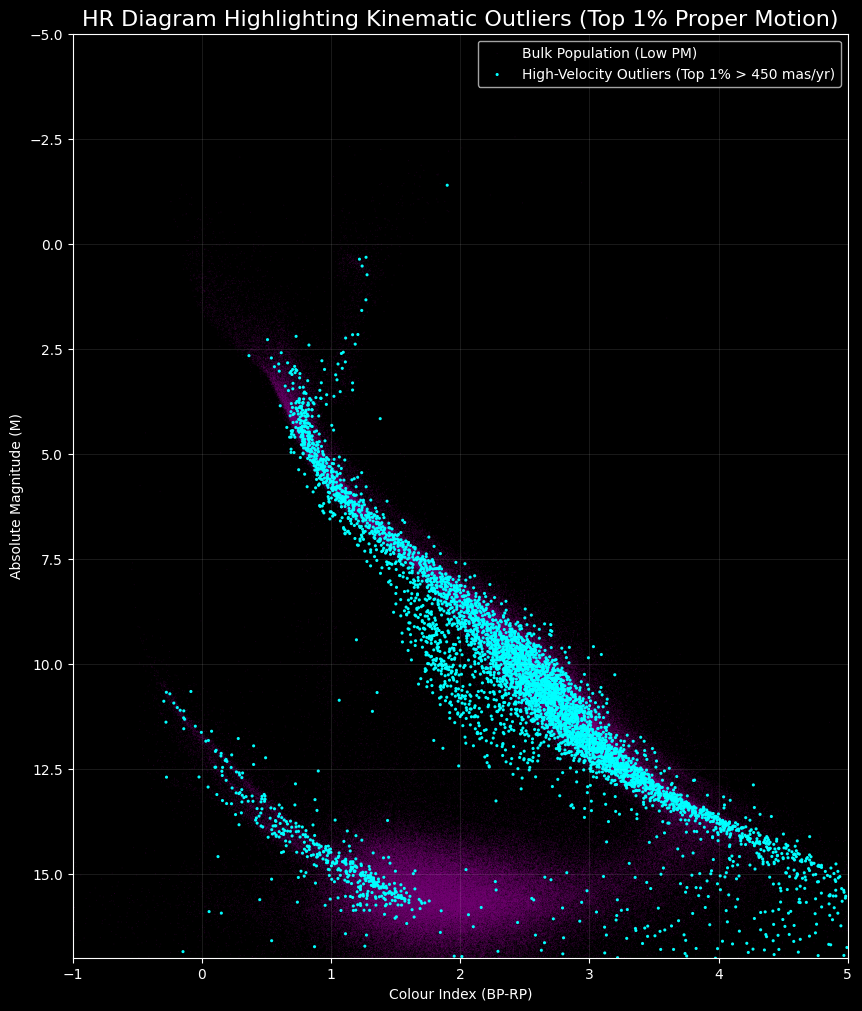

In [16]:
import matplotlib.pyplot as plt

# Filter the data into two subsets
pdf_slow = pdf_motion[pdf_motion['is_high_pm'] == 0]
pdf_fast = pdf_motion[pdf_motion['is_high_pm'] == 1]

# 1. Create the Plot Canvas
plt.figure(figsize=(10, 12))
plt.style.use('dark_background')

# 2. Plot the Bulk Population (Slow/Main Sequence)
# Use a high alpha (low transparency) colour to show the main density
plt.scatter(
    pdf_slow['bp_rp'], 
    pdf_slow['abs_mag_g'], 
    c='purple',         # Base colour
    s=0.5,              # Small size
    alpha=0.2,          # Very transparent to show density variation
    edgecolors='none', 
    label='Bulk Population (Low PM)'
)

# 3. OVERLAY the High-Velocity Stars
# Use a distinct, bright colour and larger size
plt.scatter(
    pdf_fast['bp_rp'], 
    pdf_fast['abs_mag_g'], 
    c='cyan',           # Stand-out colour
    s=5,                # Much larger size
    alpha=1.0,          # Fully opaque
    edgecolors='none',
    label=f'High-Velocity Outliers (Top 1% > {pm_threshold:.0f} mas/yr)'
)

# 4. Polish and Axes
plt.gca().invert_yaxis()  # Brighter stars (lower mag) go at the top
plt.title('HR Diagram Highlighting Kinematic Outliers (Top 1% Proper Motion)', fontsize=16)
plt.xlabel('Colour Index (BP-RP)')
plt.ylabel('Absolute Magnitude (M)')
plt.xlim(-1, 5)
plt.ylim(17, -5)
plt.legend(loc='upper right')
plt.grid(alpha=0.1)

plt.style.use('dark_background') # Dark background makes the colors pop
plt.show()